# **Titanic: A Journey to 0.78+ with Feature Engineering & Optuna**

### A step-by-step guide from basic EDA to advanced tuning, culminating in a crucial lesson about overfitting.



### **1. Introduction**

Welcome to my Titanic survival prediction notebook! This project is a classic rite of passage on Kaggle, and this notebook documents my personal journey of improving the score through a structured process.

My goal is not just to present the final code, but to share the story of exploration:
*   **Starting with fundamental Exploratory Data Analysis (EDA).**
*   **Discovering the power of Feature Engineering** (especially one feature that gave a significant boost).
*   **Leveraging Optuna** for advanced hyperparameter tuning.
*   Facing the most important lesson in machine learning: the gap between a high Cross-Validation score and the actual Leaderboard score, also known as **Overfitting**.

If you are also learning, I hope my process of trial, error, and discovery will be helpful. And if you find it useful, an **upvote** would be greatly appreciated and would help me on my quest for a bronze medal!

**Our roadmap:**
1.  **Setup & First Look (EDA):** Getting to know our data.
2.  **Feature Engineering:** Creating new features to boost performance.
3.  **Modeling & Optuna Tuning:** Building and optimizing our models.
4.  **The Moment of Truth:** Analyzing the CV vs. LB scores.
5.  **Conclusion:** Final thoughts and key takeaways.

---

### **2. Setup & First Look (EDA)**

Let's start by loading the necessary libraries and data to understand the challenge ahead.

In [1]:
# First, install the necessary libraries
# This ensures that they are available in the Kaggle commit environment
!pip install lightgbm
!pip install optuna

In [2]:
# --- 1. Load Libraries ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Machine Learning Models & Tools
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from lightgbm import LGBMClassifier
import optuna
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Settings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

# --- 2. Load Data ---
train_df = pd.read_csv('/kaggle/input/titanic/train.csv')
test_df = pd.read_csv('/kaggle/input/titanic/test.csv')
all_data = pd.concat([train_df.drop('Survived', axis=1), test_df], sort=False).reset_index(drop=True)

print("Train Data Shape:", train_df.shape)
print("Test Data Shape:", test_df.shape)
print("\nFirst 5 rows of training data:")
train_df.head()

Train Data Shape: (891, 12)
Test Data Shape: (418, 11)

First 5 rows of training data:


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Let's check for missing values and data types.

In [3]:
print("Data Info:")
train_df.info()

print("\nMissing Values:")
train_df.isnull().sum()

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB

Missing Values:


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

**Observation:** `Age`, `Cabin`, and `Embarked` have missing values. `Cabin` is missing the most data by far.

Now, let's visualize the relationship between key features and survival.

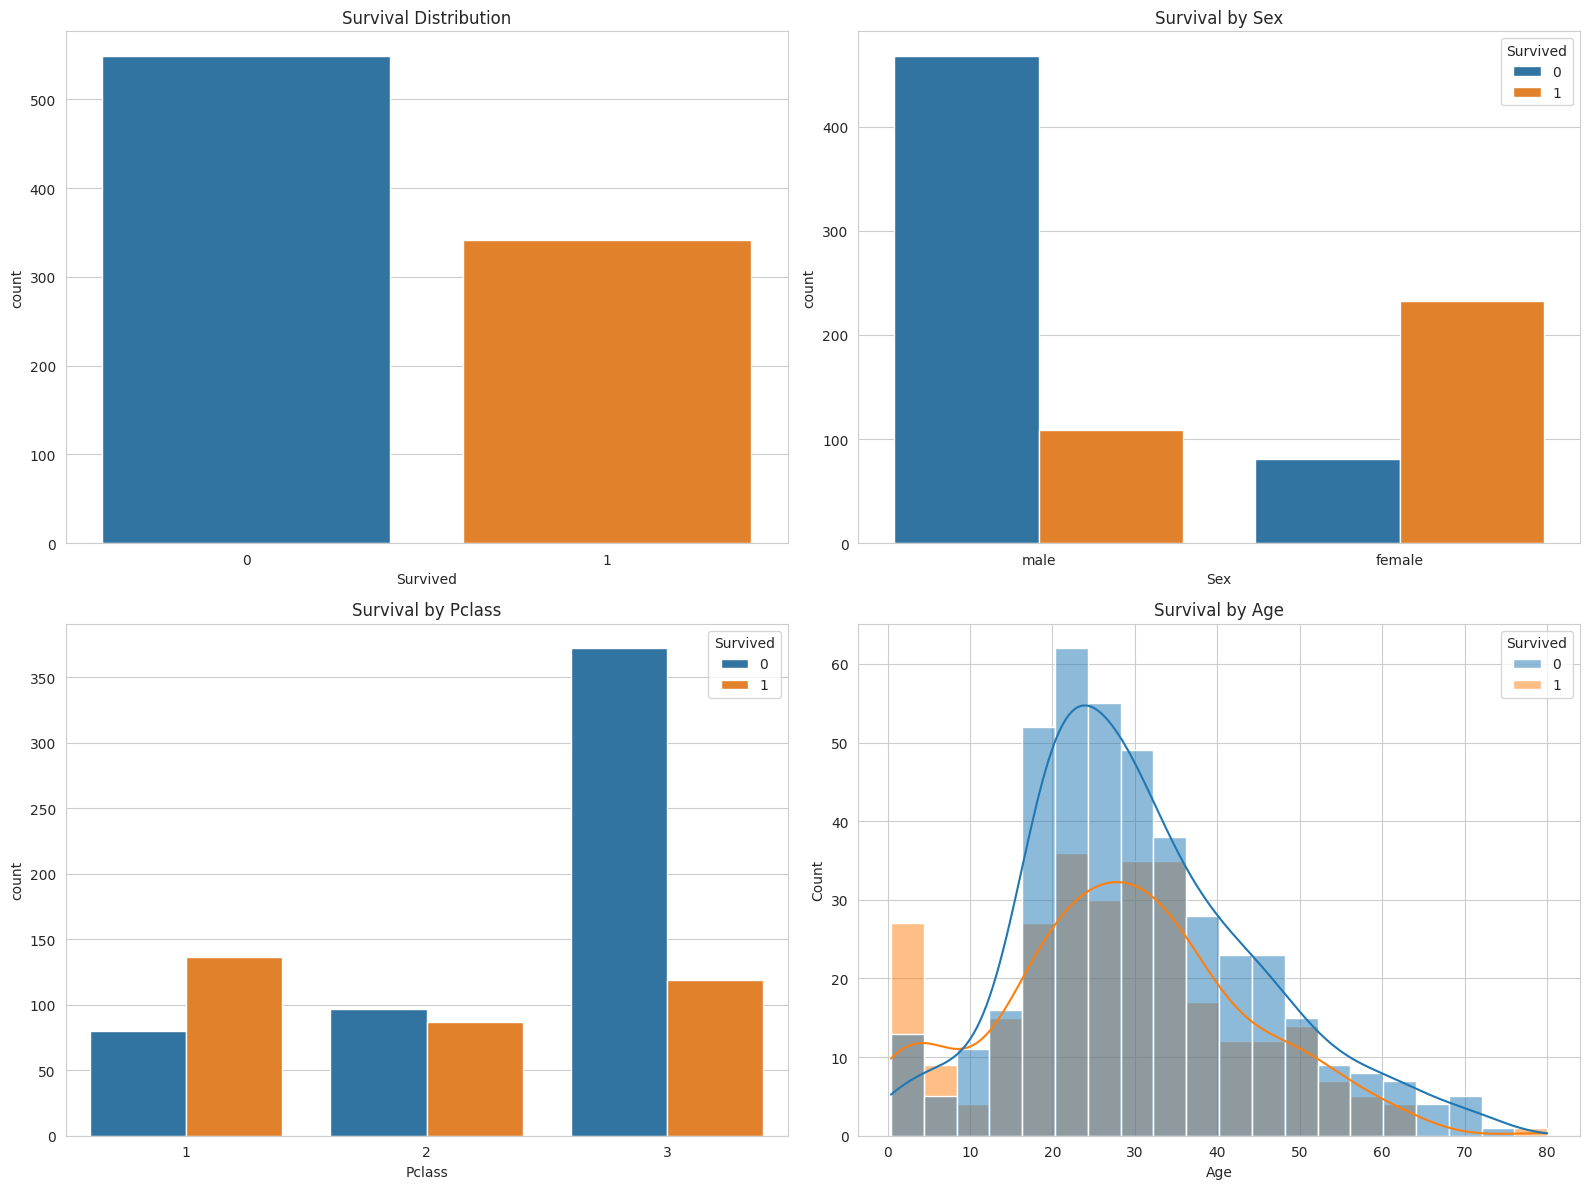

In [4]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
sns.countplot(ax=axes[0, 0], x='Survived', data=train_df)
axes[0, 0].set_title('Survival Distribution')

sns.countplot(ax=axes[0, 1], x='Sex', hue='Survived', data=train_df)
axes[0, 1].set_title('Survival by Sex')

sns.countplot(ax=axes[1, 0], x='Pclass', hue='Survived', data=train_df)
axes[1, 0].set_title('Survival by Pclass')

sns.histplot(ax=axes[1, 1], data=train_df, x='Age', hue='Survived', kde=True)
axes[1, 1].set_title('Survival by Age')

plt.tight_layout()
plt.show()

**EDA Takeaways:**
*   **Sex:** Females had a much higher chance of survival. This is a critical feature.
*   **Pclass:** Passengers in 1st class had the highest survival rate, while 3rd class had the lowest. Wealth and status mattered.
*   **Age:** Children had a slightly better chance of survival. `Age` has missing values that we must handle.

### **3. Feature Engineering: The Key to Improvement**

This is where we can make the biggest impact. Based on our EDA, we'll create new features to help our model learn.

In [5]:
# --- A. Title ---
# Extract titles like "Mr.", "Miss.", etc., from the Name column.
all_data['Title'] = all_data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
all_data['Title'] = all_data['Title'].replace(['Mlle', 'Ms'], 'Miss')
all_data['Title'] = all_data['Title'].replace('Mme', 'Mrs')
# Group rare titles into a single 'Rare' category.
rare_titles = all_data['Title'].value_counts()[all_data['Title'].value_counts() < 10].index
all_data['Title'] = all_data['Title'].replace(rare_titles, 'Rare')

# --- B. FamilySize & IsAlone ---
# Combine SibSp and Parch to get total family size.
all_data['FamilySize'] = all_data['SibSp'] + all_data['Parch'] + 1
all_data['IsAlone'] = (all_data['FamilySize'] == 1).astype(int)

# --- C. Deck ---
# Extract the first letter from the Cabin number, which represents the deck.
# 'U' stands for 'Unknown' if Cabin is missing.
all_data['Deck'] = all_data['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'U')

# --- D. Ticket_Frequency (The Game Changer!) ---
# This was my most powerful feature. The hypothesis is that people traveling on the
# same ticket number are a social group (family or friends), even if not listed in SibSp/Parch.
ticket_counts = all_data['Ticket'].value_counts()
all_data['Ticket_Frequency'] = all_data['Ticket'].map(ticket_counts)

# --- E. Impute Missing Values ---
# Impute Age based on the median age of similar Pclass and Title groups.
all_data['Age'] = all_data.groupby(['Title', 'Pclass'])['Age'].transform(lambda x: x.fillna(x.median()))
all_data['Fare'] = all_data['Fare'].fillna(all_data['Fare'].median())
all_data['Embarked'] = all_data['Embarked'].fillna(all_data['Embarked'].mode()[0])

# --- F. Fare_log (Handle Skewness) ---
# Fare is heavily skewed. A log transform helps normalize it and reduces the impact of outliers.
all_data['Fare_log'] = np.log1p(all_data['Fare'])

# --- G. Binning ---
# Convert continuous Age and Fare into categorical bins.
all_data['AgeBin'] = pd.qcut(all_data['Age'], 5, labels=False, duplicates='drop')
all_data['FareBin'] = pd.qcut(all_data['Fare_log'], 4, labels=False, duplicates='drop')

print("Feature engineering complete. New features created!")

Feature engineering complete. New features created!


### **4. Modeling & Optuna Tuning**

Now for the fun part. Our strategy is:
1.  Select three strong tree-based models: `RandomForest`, `GradientBoosting`, and `LightGBM`.
2.  Use `Optuna` to find the best hyperparameters for `LightGBM`, our most powerful model.
3.  Combine all three models into a `VotingClassifier` ensemble for a stable and robust final prediction.

#### **Data Preparation**

In [6]:
# Drop original columns that are no longer needed
drop_cols = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'Age', 'Fare', 'Fare_log', 'SibSp', 'Parch', 'FamilySize']
all_data_clean = all_data.drop(drop_cols, axis=1)

# Convert categorical features to dummy variables
all_data_encoded = pd.get_dummies(all_data_clean, columns=['Title', 'Deck', 'Embarked', 'Sex'], drop_first=True)

# Split back into training and testing sets
X_train = all_data_encoded[:len(train_df)]
X_test = all_data_encoded[len(train_df):]
y_train = train_df['Survived']

print("Final Training Data Shape:", X_train.shape)
X_train.head()

Final Training Data Shape: (891, 20)


,Pclass,IsAlone,Ticket_Frequency,AgeBin,FareBin,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_U,Embarked_Q,Embarked_S,Sex_male
0,3,0,1,1,0,False,True,False,False,False,False,False,False,False,False,False,True,False,True,True
1,1,0,2,3,3,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False
2,3,1,1,1,1,True,False,False,False,False,False,False,False,False,False,False,True,False,True,False
3,1,0,2,3,3,False,False,True,False,False,True,False,False,False,False,False,False,False,True,False
4,3,1,1,3,1,False,True,False,False,False,False,False,False,False,False,False,True,False,True,True


#### **Optuna for Hyperparameter Tuning**

`GridSearchCV` is good, but `Optuna` is smarter. It uses a Bayesian approach to efficiently search for the best parameters, saving time and often finding better results.

In [7]:
# Define the objective function for Optuna
def objective(trial):
    params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'random_state': 42
    }
    
    model = LGBMClassifier(**params)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
    return scores.mean()

# Create a study and run the optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50) # 50 trials for a good search

print(f"\nOptuna Best CV Score: {study.best_value:.4f}")
print(f"Optuna Best Params: {study.best_params}")

[I 2025-11-20 09:19:08,740] A new study created in memory with name: no-name-f4920099-3390-404a-84e4-6f59511206ac
[I 2025-11-20 09:19:09,546] Trial 0 finished with value: 0.8125478626577113 and parameters: {'n_estimators': 236, 'learning_rate': 0.1637612054249025, 'num_leaves': 98, 'max_depth': 8, 'min_child_samples': 11, 'subsample': 0.7393414665840553, 'colsample_bytree': 0.6630956181179357}. Best is trial 0 with value: 0.8125478626577113.
[I 2025-11-20 09:19:10,796] Trial 1 finished with value: 0.8226476680685456 and parameters: {'n_estimators': 637, 'learning_rate': 0.14426465487485632, 'num_leaves': 260, 'max_depth': 11, 'min_child_samples': 33, 'subsample': 0.7907556952063667, 'colsample_bytree': 0.7239232999738952}. Best is trial 1 with value: 0.8226476680685456.
[I 2025-11-20 09:19:11,289] Trial 2 finished with value: 0.8305191136777352 and parameters: {'n_estimators': 508, 'learning_rate': 0.04566163371186358, 'num_leaves': 286, 'max_depth': 3, 'min_child_samples': 18, 'subsam


Optuna Best CV Score: 0.8406
Optuna Best Params: {'n_estimators': 314, 'learning_rate': 0.08352833034522726, 'num_leaves': 89, 'max_depth': 6, 'min_child_samples': 42, 'subsample': 0.813299665084044, 'colsample_bytree': 0.9976457037751612}


### **5. The Moment of Truth: CV vs. LB & The Overfitting Wall**

With the best parameters from Optuna, we can now build our final ensemble model and submit.

In [8]:
# --- Build the Final Ensemble Model ---

# 1. Base models with solid, standard parameters
rf = RandomForestClassifier(n_estimators=200, max_depth=8, min_samples_leaf=2, random_state=42)
gb = GradientBoostingClassifier(n_estimators=300, learning_rate=0.01, max_depth=4, random_state=42)

# 2. The LGBM model with Optuna's best parameters
best_lgbm_params = study.best_params
lgbm_best = LGBMClassifier(**best_lgbm_params, random_state=42)

# 3. Combine them in a Voting Classifier
voting_clf = VotingClassifier(
    estimators=[
        ('rf', rf),
        ('gb', gb),
        ('lgbm', lgbm_best)
    ],
    voting='soft'
)

# --- Evaluate and Predict ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
final_cv_scores = cross_val_score(voting_clf, X_train, y_train, cv=cv, scoring='accuracy')
print(f"\nFinal Ensemble CV Score: {final_cv_scores.mean():.4f}")

# Fit on all training data and make predictions
voting_clf.fit(X_train, y_train)
predictions = voting_clf.predict(X_test)

# --- Create Submission File ---
submission = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': predictions
})
submission.to_csv('submission_final.csv', index=False)

print("\nSubmission file 'submission_final.csv' created successfully!")



Final Ensemble CV Score: 0.8384

Submission file 'submission_final.csv' created successfully!


#### **Results & The Great Divide**

*   **Final Ensemble CV Score:** `~0.8373`
*   **My Public Leaderboard Score:** `0.78299`

This large gap between my local cross-validation score and the Kaggle leaderboard score is a classic sign of **overfitting**. My model learned the patterns in the training data *too well*, including the noise and random quirks. As a result, its ability to generalize to new, unseen data (the test set) was reduced.

This was the most valuable lesson of the project: **a high CV score is not a guarantee of success.** The true test of a model is its performance on data it has never seen before.

### **6. Conclusion & Final Thoughts**

This journey through the Titanic dataset has been incredibly insightful. We went from basic data exploration to creating powerful features and using advanced optimization tools.

**Key Takeaways:**
*   **Feature Engineering is King:** The creation of `Ticket_Frequency` provided the most significant performance boost, proving that domain knowledge and creative thinking are critical.
*   **Optuna is a Powerful Tool:** It allowed for a more efficient and effective hyperparameter search than manual tuning or GridSearchCV.
*   **Beware the Overfitting Trap:** The gap between CV and LB scores is a crucial learning experience. It highlights the importance of creating robust, generalizable models, not just models that memorize the training data.

My final score was **0.78299**, which I am very proud of as it represents a significant improvement from the baseline.

Thank you for following along with my analysis! I hope this detailed walkthrough was helpful.

**If you enjoyed this notebook or learned something new, please consider giving it an upvote! It's the best way to show your appreciation on Kaggle.**